## Importing area

In [1]:
import civil_war_base as cw
import pandas as pd
import timeit
from itertools import compress
from country_converter import CountryConverter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as sp
from datetime import timedelta  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Forecasting civil wars
The aim of this project is to determine the causes that start a civil war to make predictions to avoid future conflicts. It will use monthly aggregations of events registered by the Integrated Crisis Early Warning System to predict the starting, ongoingness and ending of a conflict for the next month. Although most studies focus on theory, using country's data like GDP, per capita income, crime levels, etc., this project’s approach will follow recent studies using event data.

A python file called **"civil_war_base.py"** was created. It contains all the functions used in this notebook. For more information about the functions, please look them up in this file since they all contain docstrings with information. 

# 1. About the data

## 1.1. Integrated Crisis Early Warning System 
The Integrated Crisis Early Warning System ([ICEWS](https://en.wikipedia.org/wiki/Integrated_Conflict_Early_Warning_System))is a repository that contains counts of daily events worldwide. The data is currently stored in the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/28075) along with information about its content. This project uses version 29.0, with events from 1995 to April 2020. All the files are provided in the file **events.zip** in the same repository as this notebook. The file was uploaded using [Git Large File Storage](https://git-lfs.github.com/) due to its size. 

The ICEWS dataset records the "who did what to whom and where" for events across the globe. 

To simplify the description of the data, the year 2017 is used in the following. 

In [2]:
year_2017 = cw.read_events_year("events.zip",2017)
year_2017.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude
641235,28245644,11/16/2017,Grigory Borisovich Karasin,"Executive,Government,Foreign Ministry",Russian Federation,Consult,40,1.0,Zurab Abashidze,"Foreign Ministry,Executive,Executive Office,Go...",Georgia,45844863.0,2.0,Interfax News Service,Prague,NaN,Hlavni mesto Praha,Czech Republic,NaN,14.4208
553377,28096194,10/4/2017,Japan,NaN,Japan,Consult,40,1.0,Shinzo Abe,"Executive,Executive Office,Government,(Nationa...",Japan,45485869.0,1.0,Unknown,NaN,NaN,Washington D.C.,United States,38.9171,-77.0003
15189,25355567,1/11/2017,Russia,NaN,Russian Federation,Investigate,90,-2.0,Party Member (United States),Parties,United States,43192300.0,2.0,EFE News Service,New York City,NaN,state of New York,United States,NaN,-74.0060
456988,27928094,8/17/2017,"Armed Gang (Palestinian Territory, Occupied)",Unidentified Forces,Occupied Palestinian Territory,Carry out suicide bombing,1831,-10.0,Hamas,"(National) Major Party,Parties,International R...",Occupied Palestinian Territory,45082314.0,1.0,Agence France-Presse,Gaza,NaN,Gaza Strip,Occupied Palestinian Territory,NaN,34.4667
401012,27831035,7/18/2017,Head of Government (Iraq),"Executive Office,Government,Executive",Iraq,Make statement,10,0.0,Iraq,NaN,Iraq,44833123.0,6.0,EFE News Service,Mosul,NaN,Muhafazat Ninawa,Iraq,36.3350,43.1189


The table above shows some rows from the 2017 ICEWS dataset. 

### 1.1.1. Conflict and Mediation Event Observations
The Conflict and Mediation Event Observations code (CAMEO code) is a coding system for event data.  There are 20 different codes for 20 different types of events and each has different levels of subcoding. The document containing information about each code can be downloaded from the [Harvard Dataverse](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/28075/SCJPXX&version=30.0) too. 

### 1.1.2. Intensity 
The intensity value derives from teh CAMEO code. It ranges from -10 to 10, with -10 representing the most hostile events and 10 the most cooperative events. 

### 1.1.3. Cleaning the data
For the purpose of this project, it is necessary to clean the data. The cleaning process goes like this:

   **1. Select events where "Source Country" is the same as "Target Country"**: To consider only internal events that may suggest internal conflict. 
   
   A column named "Year_Month" was added to store the year and the month of the event. 

In [3]:
year_2017_internal = cw.internal_events_year("events.zip",2017)
year_2017_internal.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,...,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
445984,27908735,2017-08-10,Government (India),Government,India,Accuse,112,-2.0,Other Authorities / Officials (India),Government,...,45030957.0,6.0,The Times of India,Thiruvananthapuram,NaN,State of Kerala,India,NaN,76.9492,2017-08
203410,27490995,2017-04-18,India,NaN,India,Make statement,10,0.0,Narendra Modi,"Elite,Hindu,(National) Major Party,Opposition ...",...,44030212.0,1.0,Indo-Asian News Service,New Delhi,NaN,National Capital Territory of Delhi,India,28.6358,NaN,2017-04
551823,28092049,2017-10-04,Militant (Kurdistan Workers' Party),"International Ethnic,Kurd (Ethnic Group),Separ...",Turkey,Use unconventional violence,180,-9.0,Citizen (Turkey),"Social,General Population / Civilian / Social",...,45478683.0,1.0,Unknown,Ankara,NaN,Ankara,Turkey,39.9199,32.8543,2017-10
326935,27704213,2017-06-13,Jirí Rusnok,"Executive,Government,Elite,Executive Office",Czech Republic,Demand,100,-5.0,Lawmaker (Czech Republic),"Government,Legislative / Parliamentary",...,44535715.0,1.0,Reuters News,Prague,NaN,Hlavni mesto Praha,Czech Republic,50.0880,NaN,2017-06
506776,28013737,2017-09-11,Nirmala Sitharaman,"Executive,(National) Major Party,Parties,Oppos...",India,Express intent to meet or negotiate,36,4.0,Defense / Security Ministry (India),"Defense / Security Ministry,Government,Executive",...,45288817.0,6.0,Indo-Asian News Service,New Delhi,NaN,National Capital Territory of Delhi,India,28.6358,NaN,2017-09


**2. Simplify sectors mapping them**: Four sectors will be considered: Government (Gov), Insurgents (Ins), Opposition (Opp) and People (Peo). This will simplify the model and improve its interpretability. 

To map "Source/Target Name/Sectors" column a list of possible descriptions for each sector was used.  If the name of the country was in any of the "Source/Target Name/Sectors" columns, the sector was identified as Government. The rest were extracted from the [Actors](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/28118/HYSJN6&version=4.0) and [Agents](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/28118/JY6S7B&version=4.0) [ICEWS dictionaries](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/28118). 

Four sectors are identified:
- Government: Rules the country
- Opposition: Legal opposition to the government
- Insurgents: Rebels against the government. 
- People: Citizens of the country. Depending on the political situation they can be in favour of any of the forces above. 

In [4]:
year_2017_filtered = cw.read_filtered_data("events.zip",2017)
year_2017_filtered.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,...,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
244810,27563326,2017-05-08,Haider Al-Abadi,Gov,Iraq,Make statement,10,0.0,Militant (Iraq),NaN,...,44203080.0,5.0,BBC Monitoring Middle East,Karbala,NaN,Muhafazat Karbala',Iraq,NaN,44.0249,2017-05
29894,25383129,2017-01-19,Tim Nicholls,Gov,Australia,Make statement,10,0.0,Protester (Australia),Opp,...,43261679.0,5.0,The Courier-Mail,NaN,NaN,NaN,Australia,-35.28350,NaN,2017-01
171702,27434423,2017-04-04,Government (Hungary),Gov,Hungary,Threaten,130,-4.4,Central European University,Peo,...,43906252.0,6.0,Baltic Daily,Budapest,NaN,Budapest fovaros,Hungary,47.49800,NaN,2017-04
365817,27771827,2017-07-02,Citizen (India),Peo,India,Use unconventional violence,180,-9.0,India,Gov,...,44699625.0,3.0,The Hindu,Cochin,NaN,State of Kerala,India,NaN,76.2602,2017-07
418322,27861369,2017-07-27,Police (Ethiopia),Gov,Ethiopia,Make an appeal or request,20,3.0,Ethiopia,Gov,...,44909754.0,3.0,Xinhua News Agency,Addis Ababa,NaN,Adis Abeba Astedader,Ethiopia,9.02497,NaN,2017-07


**3. Remove irrelevant columns**: Only "Country", "Source Sectors" (renamed as "Source"), "CAMEO", "Intensity", "Target Sector" (renamed as "Target") and "Year_Month" will be considered. 

In [5]:
year_2017_cols = cw.read_cols_filtered("events.zip",2017)
year_2017_cols.sample(5)

,Country,Source,CAMEO,Intensity,Target,Year_Month
323399,Pakistan,Gov,112,-2.0,Peo,2017-06
654903,Croatia,Gov,10,0.0,Opp,2017-11
248102,Greece,Gov,10,0.0,Peo,2017-05
504,Turkey,Ins,180,-9.0,Peo,2017-01
405572,South Africa,Ins,193,-10.0,Peo,2017-07


**4. Dummy variables of interaction**: A column for each Source_Target interaction will be generated (Gov_Opp, Peo_Ins, Ins_Gov,...) containing 1 if the event happens between the column sectors and 0 if not.  

This dummy encoding of the interaction will be helpful when building the models, when aggregating by “Year_Month” and “Country”, allowing means and counts of each type of interaction.

In [6]:
year_2017_final = cw.source_target_interaction("events.zip",2017)
year_2017_final.sample(5)

,Country,CAMEO,Intensity,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
589293,India,112,-2.0,2017-10,0,0,0,0,0,0,0,0,0,1,0,0
278738,Bahrain,180,-9.0,2017-05,0,0,0,0,0,0,0,0,0,1,0,0
450379,India,173,-5.0,2017-08,0,0,1,0,0,0,0,0,0,0,0,0
170499,India,112,-2.0,2017-04,0,0,0,0,0,0,0,0,0,1,0,0
655972,India,173,-5.0,2017-11,0,0,1,0,0,0,0,0,0,0,0,0


**5. Adding ISO3 country code**: To avoid double counting a country (for example, North Korea and Republic of Korea) the ISO3 country code will be added. 

In [7]:
year_2017_iso3 = cw.iso3country("events.zip",2017)
year_2017_iso3.sample(5)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
576063,India,IND,2017-10,41,1.0,0,0,1,0,0,0,0,0,0,0,0,0
338658,United Kingdom,GBR,2017-06,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0
249545,Nigeria,NGA,2017-05,193,-10.0,0,0,1,0,0,0,0,0,0,0,0,0
229406,Saudi Arabia,SAU,2017-04,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0
160313,India,IND,2017-03,173,-5.0,1,0,0,0,0,0,0,0,0,0,0,0


To see all events considered, a file called "all_events.csv" was created:

As a final note, only about 25% of the original data was used for the models:

In [8]:
len(year_2017_iso3)/len(year_2017)

0.23731886540606764

# 1.2. Political Instability Task Force

The State Failure Problem dataset will be used to stablish the start and ending of a civil war. This dataset comes from the Political Instability Task Force ([PITF](https://en.wikipedia.org/wiki/Political_Instability_Task_Force)), which is an American project that focuses on collecting data of political conflicts and state failure. The dataset can be found on the Center of Systemic Peace [webiste](http://www.systemicpeace.org/inscrdata.html) as the [Cosolidated Cases](http://www.systemicpeace.org/inscr/PITF%20Consolidated%20Case%20List%202018.pdf) dataset. The PITF criteria to determine a civil war can be found in its [Codebook](http://www.systemicpeace.org/inscr/PITFProbSetCodebook2018.pdf). This dataset containg civil wars from 1955 to 2018. 

## 1.2.1. Cleaning the data
The original data is presented in a PDF an was converted to a **.xlsx** using a [PDF to Excel Converter](https://smallpdf.com/pdf-to-excel). The returned file contains errors. A function that reads and fixes the data was defined <code>read_PITF()</code>:

In [9]:
PITF = cw.read_PITF("PITF Consolidated Case List 2018-converted.xlsx")
PITF.sample(5)

,ISO3,Year_Month_S,Year_Month_F
127,PHL,1969-11,2018-12
116,NGA,2006-01,2018-12
7,ARM,1995-07,1996-09
59,FJI,2006-12,2006-12
169,ZMB,1996-11,1996-11


# 2. Data analysis and model building
Since the project is using monthly aggregations of events, the target variable will be a categorical one, with 4 categories: 000 (No civil war), 001 (Civil war ongoing), 010 (Civil war ending) and 100 (Civil war starting). This encoding will allow to see differences between cases more easier. For each row, the code will represent what will happen in the next month. 

Some countries do not register events for certain months. In that case, the values for each column in the missing "Year_Month" value will be filled with 0s.

To determine those difference, t-tests will be applied between cases where no civil war is taking place (000) and cases were a civil war is starting (100). This will allow to see if there is any particular difference between cases. For ongoingness (001) and ending (010) of the civil war, t-test will be used to determine differences between those cases. Statistical significance will be considered for any p-value bellow 0.05. If none of the p-values are bellow 0.05, values bellow 0.1 will be studied, although not considered statistically significant. 

Principal component analysis will be applied on each model to look at data distributions and to see how well the model separates the data between cases. It will also be used to visualise how each predictor can be relevant at predicting civil wars inspecting the two first principal components and the contributions of each predictor. 

Finally, data will be modeled with random forests. Random forests are chosen as model because they can handle outliers and noise better than the other models. They are also good at reducing overfitting, which is ideal for the imbalanced data of this project. Each random forest will be the same and have 1000 trees with a maximum of 5 leaf nodes to avoid overfitting. Models will not be tuned as the purpose of this project is not to generate the perfect model, it is to understand key factors that may lead to a civil war. To meassure the model performance, the area under the curve (AUC) of the receiving operating caracteristic curve (ROC) will be used. 

One important thing to notice is the difference in the amount of data for each month between 1995 and 2018:

In [10]:
all_events = pd.read_csv("all_events.csv", low_memory = False).drop("Unnamed: 0", axis = 1)
all_events["Year_Month"] = pd.to_datetime(all_events["Year_Month"])

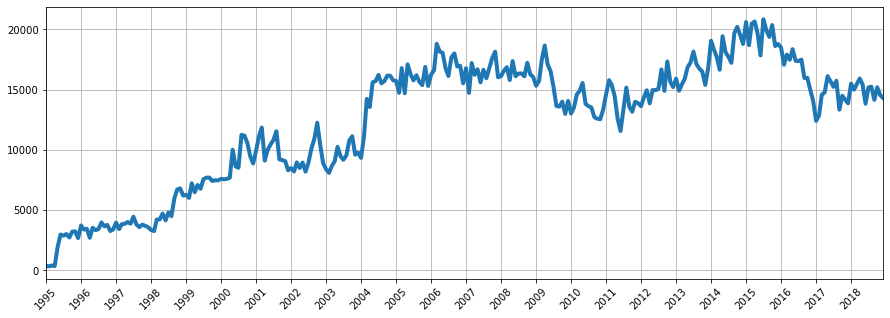

In [11]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(all_events["Year_Month"].value_counts().sort_index(), linewidth=4)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
ax.grid()
plt.xticks(rotation=45);
ax.autoscale(enable=True, axis='x', tight=True)
plt.rcParams.update({'font.size': 22})

The ammount of data in each month varies during time. Models that rely on counts can not be used, since this differences may bias the results. Relative (fraction of the total) or average models will be used to avoid this. 

For training porpuses, the model will be trained from 2004 onwards, and the rest of the data will be used as a test set. Validation will be performed using out of bag samples. 

In [12]:
all_events["Year_Month"] = all_events["Year_Month"].dt.to_period("M")

## 2.1. Interaction counts model
The interaction counts model records the number of interactions between each pair of sectors that occured during a month. The purpose of this model if to see if certain interactions increase during civil war periods. 

For that, events will be aggregated by "ISO3" and "Year_Month":

In [13]:
interaction_counts = all_events.drop(["Country","Intensity"], axis = 1) \
.groupby(["ISO3", "Year_Month"]).sum().reset_index()

Then missing months for certain countries will be added:

In [14]:
interaction_counts = cw.add_missing_months(interaction_counts)

And finaly an extra column with descriptions "000" for no civil war occuring, "001" for ongoing civil wars, "010" for ending civil wars and "100" for starting civil wars. All values are shifted one month up so that the model is able to predict for the next month (i.e., 2013-05 has what happened on 2013-06):

In [ ]:
interaction_counts = cw.add_cw(interaction_counts, "PITF Consolidated Case List 2018-converted.xlsx")

In [ ]:
interaction_counts.sample(5)

### 2.1.1. Statistical differences between predictors
This will provide information about what interactions increase or decrease during a civil war. The aim is to discover key sector interactions when predicting conflict. 

In [ ]:
# Separating events
no_civil_war = interaction_counts[interaction_counts["CW_plus1"]=="000"]
civil_war_starts = interaction_counts[interaction_counts["CW_plus1"]=="100"]
civil_war_finishes = interaction_counts[interaction_counts["CW_plus1"]=="010"]
civil_war_ongoing = interaction_counts[interaction_counts["CW_plus1"]=="001"]

One quick look at the means can help later with the p-values:

In [ ]:
cols = interaction_counts.columns[2:-1]
mean_values = pd.DataFrame(index = ["000", "100", "001", "010"], columns = cols)
mean_values.loc["000",:] = no_civil_war[cols].mean().round(4)
mean_values.loc["100",:] = civil_war_starts[cols].mean().round(4)
mean_values.loc["001",:] = civil_war_ongoing[cols].mean().round(4)
mean_values.loc["010",:] = civil_war_finishes[cols].mean().round(4)
mean_values

The means suggest that an scalation of the conflict can be derived from the data, where values for monthly aggregations without civil wars ("000") have lower values than the rest of cases ("100", "010" and "001"). Ongoing civil wars ("001") tend to have the highest means in each predcitor, and then the mean decreases at the end of a civil war ("010"). Ending civil wars have higher number of counts than starting civil wars in some predictors and sometimes have lower number of counts. 

To obtain differences between the means, t-tests will be performed. First, cases where no civil war is taking place ("000") and cases where a civil war starts ("100") will be considered:

In [ ]:
pvalues_snw = []
for i in range(0, len(cols)):
    a = no_civil_war[cols[i]]
    b = civil_war_starts[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_snw.append((cols[i], pvalue))
pd.DataFrame(pvalues_snw).set_index(0).sort_values(1).round(3).transpose()

Three columns have p-values bellow the threshold of 0.05, meaning that this columns have statistically different mean values. Their means are:

In [ ]:
mean_values.loc[["000","100"],["Ins_Gov", "Peo_Gov", "Gov_Peo"]]

For all columns, the total number of registered events increase significantly when a civil war is about to start. In the first two columns where the difference is significant the Government is the target, and it interacts with either People or Insurgents. The last column includes Government as the Source and People as the target. 

To determine if a civil war is continuing or is going to end, p-values for the differences between predictors are.

In [ ]:
pvalues_of = []
for i in range(0, len(cols)):
    a = civil_war_finishes[cols[i]]
    b = civil_war_ongoing[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_of.append((cols[i], pvalue))
pd.DataFrame(pvalues_of).set_index(0).sort_values(1).transpose()

There are 6 p-values bellow 0.05. In fact, these p-values are very low. The means for each case are:  

In [ ]:
mean_values.loc[["001","010"],["Opp_Peo", "Gov_Opp", "Opp_Gov", "Gov_Peo", "Peo_Gov", "Peo_Opp"]]

So when a civil war is about to end, these predictors decrease significantly. This suggest that a relaxation of the conflict occurs. Opposition this time is more relevant than Insurgents, with it being either the source or the target with Government and People. Interaction between People and Government is also present. 

### 2.1.2. Principal component analysis
Data will be standarized to perform PCA:

In [ ]:
# Data
data = interaction_counts.iloc[:,2:-1]

# Standardize
ss = StandardScaler()
data = ss.fit_transform(data)

In [ ]:
pca = PCA(2)
pca.fit(data)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
np.sum(pca.explained_variance_ratio_)

The two first principal components explain about 75% of the total variation in the data. This is very relevant, since each component can give a deeper insight into our model. To visualize the results, these two first principal components will be used:

In [ ]:
data_transformed = pca.transform(data)

In [ ]:
f, ax = plt.subplots(ncols = 3, figsize = (20,5))
ax[0].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[0].scatter(data_transformed[interaction_counts["CW_plus1"]=="100",0], 
            data_transformed[interaction_counts["CW_plus1"]=="100",1], alpha = 0.5)
ax[0].legend(["All values", "100"], prop={'size': 12})
ax[1].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[1].scatter(data_transformed[interaction_counts["CW_plus1"]=="010",0], 
            data_transformed[interaction_counts["CW_plus1"]=="010",1], alpha = 0.5)
ax[1].legend(["All values", "010"], prop={'size': 12})
ax[2].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[2].scatter(data_transformed[interaction_counts["CW_plus1"]=="001",0], 
            data_transformed[interaction_counts["CW_plus1"]=="001",1], alpha = 0.5)
ax[2].legend(["All values", "001"], prop={'size': 12})

The values are displayed in a fan-shaped distribution. Starting and ending civil wars tend to be towards the peak of the fan (0,0), while ongoing civil wars are distributed throughout the global distribution. 

Starting civil wars tend to be near the lower edge of the fan-shaped distribution, while ending civil wars tend to be near the top edge. This suggest that the second principal component separates the data between starting and ending civil wars. 

Predictors sorted by relevance in the first component are:

In [ ]:
components = pd.DataFrame(pca.components_).transpose()
sorted_cols = components[0].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,0]) for i in sorted_cols]

Most of the predictors are very close to 0.3, suggesting that they all are relevant for the first component. Interactions between Insurgents and the Opposition have lower coeficients. *"Ins_Gov"* has also a lower coeficient than the rest of the predictors.

For the second component:

In [ ]:
sorted_cols = components[1].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,1]) for i in sorted_cols]

Interaction between Insurgents and Government are the predictors with a higher coeficient in the second component. The most relevant predictor is *"Ins_Gov"*. 

Since starting civil wars tended to be on the lower edge of the fan-shaped distribution, this means that starting civil wars have a negative second component value, while ending civil wars have a positive second component value. This means that, after standarization, starting civil wars have higher values of where coeficients have a negative value (*"Gov_Opp"*, *"Opp_Gov"*, *"Peo_Opp"*,...) than ending civil wars. This is similar to the results obtained from the means of each column, where depending on the predictor, ending civil wars had lower values than starting civil wars. 

### 2.1.3. Training the model
Selecting the training and testing sets splitting them in 2004:

In [ ]:
date_filter = "2004-01"

Xtrain = interaction_counts[interaction_counts["Year_Month"]>=date_filter].iloc[:,2:-1]
ytrain = interaction_counts[interaction_counts["Year_Month"]>=date_filter].iloc[:,-1]

Xtest = interaction_counts[interaction_counts["Year_Month"]<date_filter].iloc[:,2:-1]
ytest = interaction_counts[interaction_counts["Year_Month"]<date_filter].iloc[:,-1]

Training the model:

In [ ]:
rf1 = RandomForestClassifier(random_state = 1492, n_estimators = 1000, oob_score = True,
                               criterion = "entropy", max_leaf_nodes=5);
rf1.fit(Xtrain, ytrain)

Evaluating model performance from out of bag samples:

In [ ]:
ytrain_score = rf1.oob_decision_function_

In [ ]:
classes = rf1.classes_
f, ax = plt.subplots()
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytrain==classes[i], ytrain_score[:,i]))
    fp, tp, _ = roc_curve(ytrain==classes[i], ytrain_score[:,i])
    ax.plot(fp, tp)
ax.plot([0,1],[0,1]) 
plt.rcParams.update({'font.size': 12});
plt.legend(["000","001","010","100","Random model"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

We see that our model is capturing the differences between the different types of cases. A random model has an AUC of 0.5 and all target variables had an AUC over 0.5. The model works best at predicting cases where a civil war is not occurring ("000") or ongoing ("001"). Due to the lack of samples (around 20 in the training set), the other two cases have a lower score (0.643 for ending civil wars "010" and 0.696 for starting civil wars "100"), but still over 0.5.

Finally, checking the results with the test set:

In [ ]:
ypred = rf1.predict_proba(Xtest)

In [ ]:
f, ax = plt.subplots()
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytest==classes[i], ypred[:,i]))
    fp, tp, _ = roc_curve(ytest==classes[i], ypred[:,i])
    ax.plot(fp, tp)
ax.plot([0,1],[0,1]) 
plt.legend(["000","001","010","100","Random model"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.rcParams.update({'font.size': 12});

The results obtained from the test set are very similar to the out of bag predictions. Although a little bit lower suggesting a certain level of overfitting.

Finaly, the model's predictor importance:

In [ ]:
importance = rf1.feature_importances_
importance_list = []

for i in range(0,len(Xtrain.columns)):
    importance_list.append((Xtrain.columns[i], importance[i]))

importance_df = pd.DataFrame(importance_list, columns = ["Predictor","Importance"])

In [ ]:
pd.set_option('display.max_columns', None)
importance_df.sort_values("Importance", ascending = False).transpose()

The higher importance of a predictor is for *"Ins_Gov"*, which was the lowest p-value to diferenciate between peace and the start of a civil war and the top of the coeficients that affected the second principal componend which splitted starting and ending civil wars. 

Insurgents are present in the first 4 predictors.

### 2.1.4. Conclusions

The main problem of this problem is that is very opaque. The only useful information is the number of events registered, but it does not provide information on what kind of interaction lead to conflict. It is also worth noticing that People is a sector that contains individuals that can be in either side, with the Government, with Insurgents or with the Opposition. So this is still something that the current model fails to capture. 

### 2.2. Total intensity
The intensity of each event is registered in the *"Intensity"* column of the original dataset. It measures the scale of the event from -10 to 10, with -10 being the less cooperative interaction and 10 the most cooperative. This column can be used to see the sum of the interaction for each source-target pair. The purpose of this model is to solve the lack of information of the previous one. This way, a way of meassuring the interaction exists.

To generate the model:

In [ ]:
cols = all_events.columns[5:]
total_intensity = all_events.loc[:,["ISO3", "Year_Month"]]
for col in cols:
    total_intensity[col] = all_events.loc[:,col]
    total_intensity.loc[:,col] = total_intensity.loc[:,col]*all_events.loc[:,"Intensity"]

In [ ]:
total_intensity = total_intensity.groupby(["ISO3", "Year_Month"]).sum().reset_index()
total_intensity = cw.add_missing_months(total_intensity)
total_intensity = cw.add_cw(total_intensity, "PITF Consolidated Case List 2018-converted.xlsx")

In [ ]:
total_intensity.sample(5)

### 2.2.1. Statistical differences between predictors
Once again, t-tests will be used to determine statistical differences between the means. First, the means for each predictor will be obtained:

In [ ]:
# Separating events
no_civil_war = total_intensity[total_intensity["CW_plus1"]=="000"]
civil_war_starts = total_intensity[total_intensity["CW_plus1"]=="100"]
civil_war_finishes = total_intensity[total_intensity["CW_plus1"]=="010"]
civil_war_ongoing = total_intensity[total_intensity["CW_plus1"]=="001"]

In [ ]:
# Means
cols = total_intensity.columns[2:-1]
mean_values = pd.DataFrame(index = ["000", "100", "001", "010"], columns = cols)
mean_values.loc["000",:] = no_civil_war[cols].mean().round(4)
mean_values.loc["100",:] = civil_war_starts[cols].mean().round(4)
mean_values.loc["001",:] = civil_war_ongoing[cols].mean().round(4)
mean_values.loc["010",:] = civil_war_finishes[cols].mean().round(4)
mean_values

All means are negative, with the only positive mean bein for *"Opp_Ins"* at the end of a civil war.

To see statistical differences between the means for periods of peace and the start of a civil war:

In [ ]:
pvalues_snw = []
for i in range(0, len(cols)):
    a = no_civil_war[cols[i]]
    b = civil_war_starts[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_snw.append((cols[i], pvalue))
pd.DataFrame(pvalues_snw).set_index(0).sort_values(1).round(3).transpose()

Only one predictor has a value bellow 0.05, that is the *"Ins_Gov"* predictor. The means in this case are:

In [ ]:
mean_values.loc[["000","100"],["Ins_Gov"]].transpose()

So when the civil war start, the intensity of the interaction where Insurgents are the source and Government is the target decreases. This suggests that attacks from insurgents to the government (whether armed or verbal) start to happen. So a good way to determine if a civil war is about to start is to see if the intensity of the actions from Insurgents to the Government decreases. 

The differences between ongoing civil wars and ending civil wars are:

In [ ]:
pvalues_of = []
for i in range(0, len(cols)):
    a = civil_war_finishes[cols[i]]
    b = civil_war_ongoing[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_of.append((cols[i], pvalue))
pd.DataFrame(pvalues_of).set_index(0).sort_values(1).transpose()

7 predictors have a p-value bellow 0.05. To see the difference between means:

In [ ]:
mean_values.loc[["001","010"],["Opp_Gov","Gov_Opp","Gov_Peo","Peo_Gov","Opp_Peo","Peo_Ins","Peo_Opp"]]

All predictors tend to increase their intensity at the end of the conflict. This suggests relaxation of the conflict. So a good way to determine if a civil war is going to end is to see if the intensity of the interaction between the sectors specified above drops significantly.  

### 2.2.2. Principal component analysis
Again, this is to see if the model is able to split the data and to extract information from the main two principal components:

In [ ]:
data = total_intensity.iloc[:,2:-1]

# Standardize
ss = StandardScaler()
data = ss.fit_transform(data)

In [ ]:
pca = PCA(2)
pca.fit(data)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
np.sum(pca.explained_variance_ratio_)

The first two principal components explain about 59% of the total variation, which is less than the previous model. To see how the data is distributed with these two components, the transformation under the principal components will be made:

In [ ]:
data_transformed = pca.transform(data)

In [ ]:
f, ax = plt.subplots(ncols = 3, figsize = (20,5))
ax[0].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[0].scatter(data_transformed[total_intensity["CW_plus1"]=="100",0], 
            data_transformed[total_intensity["CW_plus1"]=="100",1], alpha = 0.5)
ax[0].legend(["All values", "100"], prop={'size': 12})
ax[1].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[1].scatter(data_transformed[total_intensity["CW_plus1"]=="010",0], 
            data_transformed[total_intensity["CW_plus1"]=="010",1], alpha = 0.5)
ax[1].legend(["All values", "010"], prop={'size': 12})
ax[2].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[2].scatter(data_transformed[total_intensity["CW_plus1"]=="001",0], 
            data_transformed[total_intensity["CW_plus1"]=="001",1], alpha = 0.5)
ax[2].legend(["All values", "001"], prop={'size': 12})

The results using PCA are very similar to the ones of the previous model. The distribution is agian fan-shaped, however, this time starting civil wars are near the top edge of the distribution and ending civil war near the lower edge. Ongoing civil wars are still very scattered. 

To see what predictors contribute more to each principal component:

In [ ]:
components = pd.DataFrame(pca.components_).transpose()
sorted_cols = components[0].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,0]) for i in sorted_cols]

The results are very similar to the ones on the previous model, with the interaction between People and Government at the top of the predictors for the first component. 

For the second component, the one that is, again, separating starting civil wars with ending civil wars:

In [ ]:
components = pd.DataFrame(pca.components_).transpose()
sorted_cols = components[1].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,1]) for i in sorted_cols]

This time predictors change in comparison with the ones in the previous model. 

Since starting civil wars have a positive value in the second principal component, this suggest that predictors with a negative coefficient have a lower value for starting civil wars (*"Gov_Opp"*, *"Opp_Gov"*, *"Peo_Opp"*, ...), because the mean intensity is negative (a negative number times a negative number is positive). This are the same predictors that where relevant to starting civil wars in the previous model. 

### 2.2.3. Training the model

In [ ]:
date_filter = "2004-01"

Xtrain = total_intensity[total_intensity["Year_Month"]>=date_filter].iloc[:,2:-1]
ytrain = total_intensity[total_intensity["Year_Month"]>=date_filter].iloc[:,-1]

Xtest = total_intensity[total_intensity["Year_Month"]<date_filter].iloc[:,2:-1]
ytest = total_intensity[total_intensity["Year_Month"]<date_filter].iloc[:,-1]

In [ ]:
rf2 = RandomForestClassifier(random_state = 1492, n_estimators = 1000, oob_score = True,
                               criterion = "entropy", max_leaf_nodes=5);
rf2.fit(Xtrain, ytrain)

To see how the model works, out of bag samples will be used:

In [ ]:
ytrain_score = rf2.oob_decision_function_

In [ ]:
classes = rf2.classes_
f, ax = plt.subplots()
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytrain==classes[i], ytrain_score[:,i]))
    fp, tp, _ = roc_curve(ytrain==classes[i], ytrain_score[:,i])
    ax.plot(fp, tp)
ax.plot([0,1],[0,1]) 
plt.rcParams.update({'font.size': 12});
plt.legend(["000","001","010","100","Random model"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

There is a very subtle improvement from the previous model, but results are very similar, suggesting that the model did not improve the prediction results. 

In [ ]:
ypred = rf2.predict_proba(Xtest)

In [ ]:
f, ax = plt.subplots()
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytest==classes[i], ypred[:,i]))
    fp, tp, _ = roc_curve(ytest==classes[i], ypred[:,i])
    ax.plot(fp, tp)
ax.plot([0,1],[0,1]) 
plt.legend(["000","001","010","100","Random model"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.rcParams.update({'font.size': 12});